# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [1]:
# TODO: convex hull of 1 point is the point itself, convex hull of 2 points is also the points themselves

In [2]:
import math

# Utility functions

def is_counter_clockwise(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float]) -> bool:
    # vector product to check if p3 is to the left of the line p1 -> p2
    area = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    return area > 0

def get_min_y_index(input_set: list[tuple[float, float]]) -> int:
    min_y = math.inf
    min_y_index = 0
    for i in range(len(input_set)):
        if input_set[i][1] < min_y:
            min_y = input_set[i][1]
            min_y_index = i
    return min_y_index

def distance(p1: tuple[float, int], p2: tuple[float, float]) -> float:
        return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def sort_by_polar_angle(p0: tuple[float, float], input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    input_set.sort(key=lambda p: math.atan2(p[1] - p0[1], p[0] - p0[0]))
    return input_set

def leftmost_point(points):
        # Return the point with the smallest x (and smallest y if necessary)
        return min(points)

In [3]:
def jarvis_march(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    P = []  # Resulting convex hull
    i = 0

    while True:
        P.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        endpoint = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            if endpoint == point_on_hull or is_counter_clockwise(P[i], endpoint, input_set[j]):
                # Found a more counterclockwise point
                endpoint = input_set[j]

        i += 1  # Increment the index for the hull points list
        point_on_hull = endpoint

        # Check if we have wrapped around to the first point
        if endpoint == P[0]:
            break

    return P

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [4]:
def graham_scan(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    if len(input_set) < 3:
        return input_set
    stack = []
    min_y_index = get_min_y_index(input_set)
    input_set[0], input_set[min_y_index] = input_set[min_y_index], input_set[0]
    p0 = input_set[0]
    sort_by_polar_angle(p0, input_set)
    stack.append(p0)
    stack.append(input_set[1])
    for i in range(2, len(input_set)):
        while len(stack) > 1 and not is_counter_clockwise(stack[-2], stack[-1], input_set[i]):
            stack.pop()
        stack.append(input_set[i])
    return stack

In [5]:
import matplotlib.pyplot as plt

def plot_points(input_set: list[tuple[float, float]], output_set: list[tuple[float, float]]) -> None:
    x = [i[0] for i in input_set]
    y = [i[1] for i in input_set]
    plt.scatter(x, y)
    x = [i[0] for i in output_set]
    y = [i[1] for i in output_set]
    # close the loop
    x.append(output_set[0][0])
    y.append(output_set[0][1])
    plt.plot(x, y)
    plt.show()

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [6]:
# TODO: could greatly benefit from keeping track of which hulls each point is in when choosing the next point

def partition_points(input_set: list[tuple[float, float]], num_partitions: int) -> list[list[tuple[float, float]]]:
    partition_size = math.ceil(len(input_set) / num_partitions)
    return [input_set[i:i + partition_size] for i in range(0, len(input_set), partition_size)]

def orientation(p: tuple[float, float], q: tuple[float, float], r: tuple[float, float]) -> int:
    # 0 -> colinear, 1 -> clockwise, -1 -> counterclockwise
    area = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if area == 0:
        return 0
    return 1 if area > 0 else -1

def find_tangent(p: tuple[float, float], hull: list[tuple[float, float]]) -> tuple[float, float]:
    if len(hull) == 1:
        return hull[0]
        
    n = len(hull)
    left, right = 0, n - 1

    left_before = orientation(p, hull[0], hull[-1])
    left_after = orientation(p, hull[0], hull[(left + 1) % n])

    while left < right:
        mid = (left + right) // 2

        if hull[mid] == p:
            return hull[mid+1]

        mid_before = orientation(p, hull[mid], hull[abs(mid - 1) % n])
        mid_after = orientation(p, hull[mid], hull[(mid + 1) % n])
        mid_side = orientation(p, hull[left], hull[mid])
 
        if mid_before != -1 and mid_after != -1:
            return hull[mid]
        elif (mid_side == 1 and (left_after == -1 or left_before == left_after)) \
                or (mid_side == -1 and mid_before == -1):
            right = mid
        else:
            left = mid + 1
            left_before = -mid_after
            left_after = orientation(p, hull[left], hull[(left + 1) % n])
        
    return hull[left]

def visualize_convex_hulls(
        partitions: list[tuple[float, float]],
        hulls: list[list[tuple[float, float]]], 
    ) -> None:

    for i in range(len(hulls)):
        x = [i[0] for i in partitions[i]]
        y = [i[1] for i in partitions[i]]
        plt.scatter(x, y)
        x = [i[0] for i in hulls[i]]
        y = [i[1] for i in hulls[i]]
        # close the loop
        x.append(hulls[i][0][0])
        y.append(hulls[i][0][1])
        plt.plot(x, y)
        
    plt.show()

def _chan(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    partitions = partition_points(input_set, m)
    
    # find convex hulls of each partition
    hulls = [graham_scan(partition) for partition in partitions]
    
    # merge the convex hulls
    convex_hull = []
    
    next_point = leftmost_point(input_set)
    
    for _ in range(m):
        convex_hull.append(next_point)
        end_point = find_tangent(next_point, hulls[0])

        for i in range(1, len(hulls)):
            p = find_tangent(convex_hull[-1], hulls[i])
            if end_point == next_point or is_counter_clockwise(convex_hull[-1], end_point, p):
                end_point = p

        next_point = end_point

        if next_point == convex_hull[0]:
            return convex_hull
        
    return None

def chan(input_set: list[tuple[float, float]]) -> list[tuple[float, float]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan(input_set, m)
        if output_set is not None:
            return output_set
        m = min(m * m, n)
        
    return None

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [7]:
import random

# TODO: revise the randomness of the data generation, for example have a Random generator
class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    # TODO: have a way to control the number of vertices in the convex hull and the number of points in the input set

    def __init__(self, test_size: int, seed: int | None = None):
        self.test_size = test_size
        self._rng = random.Random(seed)

    def set_seed(self, seed: int) -> None:
        self._rng.seed(seed)

    def generate_colinear_points(self) -> list[tuple[float, float]]:
        points = []
        slope = random.randint(-5,5)
        intercept = random.randint(-10,10)
        for _ in range(self.test_size):
            x = random.gauss(0,1)
            y = slope * x + intercept
            points.append((x, y))
        return points

    def generate_concentric_circles(self) -> list[tuple[float, float]]:
        list_of_points = []
        for _ in range(self.test_size):
            x = self._rng.uniform(-1, 1)
            list_of_points.append((x, math.sqrt(1 - x**2) * self._rng.choice([1, -1])))
        return list_of_points
    
    def generate_filled_disk(self) -> list[tuple[float, float]]:
        list_of_points = []
        # generate points around the unit circle
        for _ in range(self.test_size // 2):
            x = self._rng.uniform(-1, 1)
            list_of_points.append((x, math.sqrt(1 - x**2) * self._rng.choice([1, -1])))

        # generate points inside the unit circle
        for _ in range(self.test_size // 2):
            x = self._rng.uniform(-1, 1)
            y = self._rng.uniform(-1, 1)
            if x**2 + y**2 < 1:
                list_of_points.append((x, y))
        return list_of_points

    def generate_random_points(self) -> list[tuple[int, int]]:
        return [(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(self.test_size)]
        
    def generate_random_points_with_outliers(self, num_points=100):
       random_points = [(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(num_points)]
       outliers = []
       for _ in range(3):
           outliers.append((self._rng.uniform(-20, 20), self._rng.uniform(-20, 20)))  
       points_with_outliers = random_points + outliers
       return points_with_outliers


Chan: 0.031063683399406728
Jarvis March: 1.4780127375008305
Graham Scan: 0.007245558300928679


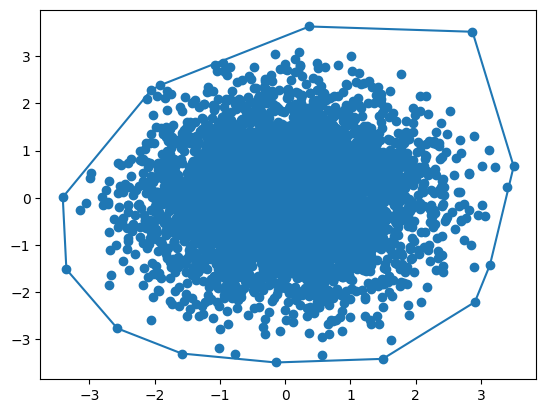

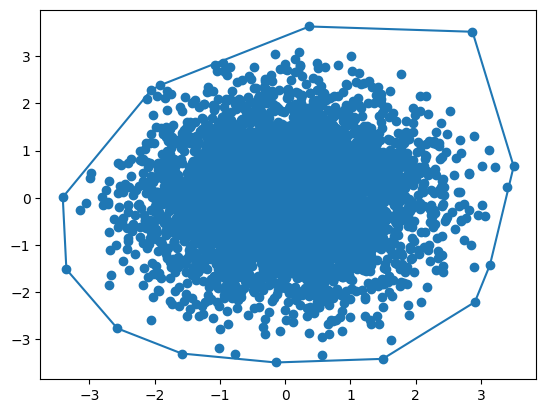

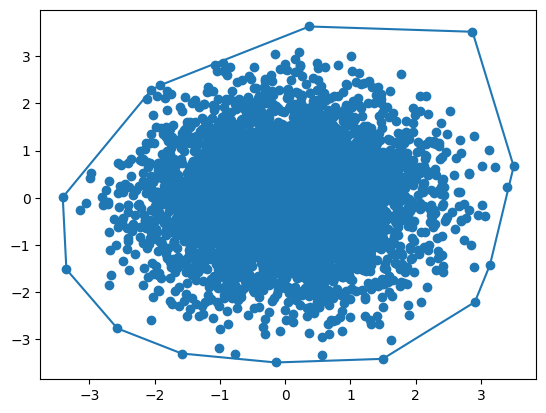

In [8]:
import timeit

data_generator = TestDataGenerator(test_size=5000)
def time_algorithm(algorithm):
    start = timeit.default_timer()
    num_runs = 10
    data_generator.set_seed(0)
    for i in range(num_runs):
        input_set = data_generator.generate_filled_disk()
        algorithm(input_set)
    end = timeit.default_timer()
    return (end - start) / num_runs

# Time the algorithms
print("Chan:", time_algorithm(chan))
print("Jarvis March:", time_algorithm(jarvis_march))
print("Graham Scan:", time_algorithm(graham_scan))

# Visualize the convex hulls
input_set = data_generator.generate_random_points()
plot_points(input_set, chan(input_set))
plot_points(input_set, jarvis_march(input_set))
plot_points(input_set, graham_scan(input_set))

Use the cell below to implement the requested **experimental framework** API.

In [ ]:
import timeit
import matplotlib

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__():
        pass

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [ ]:
# ADD YOUR TEST CODE HERE 



